In [8]:
!pip install node2vec

In [9]:
from node2vec import Node2Vec

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.cloud import bigquery


import sys
from io import BytesIO
from tensorflow.python.lib.io import file_io
from model.dataloader import *
from model.tokenizer import *
from google.cloud import bigquery

import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from networkx.algorithms import approximation

In [11]:
client = bigquery.Client(location="US")
print("Client creating using default project: {}".format(client.project))

Client creating using default project: res-nbcupea-dev-ds-sandbox-001


In [4]:
query = """
        WITH token_table AS ( 
            SELECT  cmv.TitleDetails_title AS title,
                    SPLIT(REGEXP_REPLACE(LOWER(TitleDetails_LongSynopsis), '[^a-zA-Z0-9 -]', ''), ' ') AS tokens, -- filter out non-alphabetical characters
                    sil.adobe_tracking_id AS user_id
            FROM `res-nbcupea-dev-ds-sandbox-001.recsystem.ContentMetadataView-Dat` cmv -- join on video_id
            JOIN `res-nbcupea-dev-ds-sandbox-001.silverTables.SILVER_VIDEO` sil
            ON cmv.ViewingModeVOD_ContentId = sil.video_id
            WHERE   cmv.TitleSubgenres = 'Sports' -- sports specific
                AND sil.adobe_date >= DATE_ADD(CURRENT_DATE,INTERVAL -30 DAY) -- last 30 days of data
        ),

        #unnest token
        token_clean AS (
        SELECT user_id, token, COUNT(*) AS count
        FROM token_table
        CROSS JOIN UNNEST(tokens) token
        GROUP BY user_id, token
        )

        #remove stop words
        SELECT user_id, token, count
        FROM token_clean t
        LEFT OUTER JOIN `res-nbcupea-dev-ds-sandbox-001.recsystem.stop_words_en_sp` stop
        ON stop.string_field_0 = t.token
        WHERE stop.string_field_0 IS NULL
        """
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

df = query_job.to_dataframe()
df.head()

,user_id,token,count
0,lYefCekjAkM5LO636I1qGmJaxmPoUtTk2w1wuWPTU9k=,poker,1537
1,y8DdcrfT/AOevQqsC/Gk8X43Vn5qJqyrzVahbqJ7eXs=,tournaments,3061
2,ZcgZSCaveFDLGIY9Wjrm/wchT45LBy5Xi8lp+CXagHI=,galfond,120
3,FHrlsevndmYtjq/NxpkIWUDGeL4tIvf4hlPO6n6pHzE=,host,86
4,llc91pBdCu3+Mpwe3n3fG0OaKqpxwtp7/6lkpJnJ2cY=,carillo,11


In [5]:
df.shape

(289950, 3)

In [6]:
df['user_id'].nunique()

12292

## Loading the graph data

In [8]:
%%bigquery edges
WITH token_table AS ( 
    SELECT  cmv.TitleDetails_title AS title,
            SPLIT(REGEXP_REPLACE(LOWER(TitleDetails_LongSynopsis), '[^a-zA-Z0-9 -]', ''), ' ') AS tokens, -- filter out non-alphabetical characters
            sil.adobe_tracking_id AS user_id
    FROM `res-nbcupea-dev-ds-sandbox-001.recsystem.ContentMetadataView-Dat` cmv -- join on video_id
    JOIN `res-nbcupea-dev-ds-sandbox-001.silverTables.SILVER_VIDEO` sil
    ON cmv.ViewingModeVOD_ContentId = sil.video_id
    WHERE   cmv.TitleSubgenres = 'Sports' -- sports specific
        AND sil.adobe_date >= DATE_ADD(CURRENT_DATE,INTERVAL -30 DAY) -- last 30 days of data
),

#unnest token
token_clean AS (
SELECT user_id, token, COUNT(*) AS count
FROM token_table
CROSS JOIN UNNEST(tokens) token
GROUP BY user_id, token
)

#remove stop words
SELECT user_id, token, count
FROM token_clean t
LEFT OUTER JOIN `res-nbcupea-dev-ds-sandbox-001.recsystem.stop_words_en_sp` stop
ON stop.string_field_0 = t.token
WHERE stop.string_field_0 IS NULL

In [9]:
edges['weight'] = 1 / edges['count']

In [10]:
graph = nx.from_pandas_edgelist(edges, 'user_id', 'token', ['count'])

## High-level summaries

In [11]:
print("The number of edges is:", graph.size())
print("The number of nodes:", graph.order())

The number of edges is: 289950
The number of nodes: 15229


## Connected components

In [12]:
co_co = list(nx.connected_components(graph))
print("There are", len(co_co), "connected components.")

There are 2 connected components.


In [13]:
co_co_sizes = np.array([len(co) for co in co_co])
co_co_sizes[co_co_sizes > 0]
print("The largest connected component has", max(co_co_sizes), "nodes")

The largest connected component has 15227 nodes


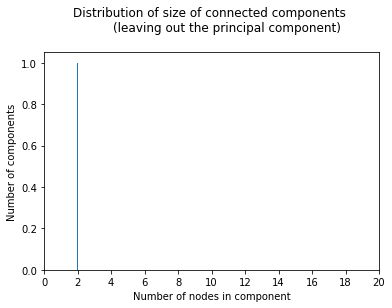

In [14]:

plt.title(
    """Distribution of size of connected components 
        (leaving out the principal component)
    """
)
plt.ylabel("Number of components")
plt.xlabel("Number of nodes in component")
plt.hist(co_co_sizes[co_co_sizes < 22], bins=21)
plt.xticks(range(0, 21, 2))
plt.show()

In [15]:
co_co[1]

{'nbcbfaatallahontyrod200929', 'yBDNQ9QHEz6e/yMc3jqmMATmD2LjB9xKDrrc7ADcSAA='}

## Vertex degrees

In [16]:
degrees = np.array([deg for _, deg in graph.degree()])
print("The vertex with most incoming/outgoing edges has", max(degrees),"edges")

The vertex with most incoming/outgoing edges has 4690 edges


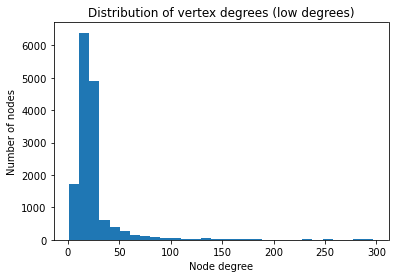

In [17]:
plt.title("Distribution of vertex degrees (low degrees)")
plt.ylabel("Number of nodes")
plt.xlabel("Node degree")
plt.hist(degrees[degrees < 300], bins=30)
plt.show()

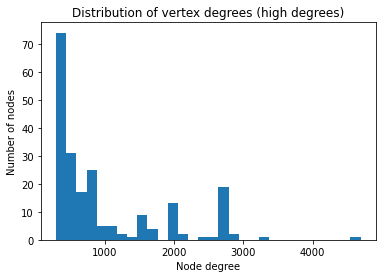

In [18]:
plt.title("Distribution of vertex degrees (high degrees)")
plt.ylabel("Number of nodes")
plt.xlabel("Node degree")
plt.hist(degrees[degrees > 300], bins=30)
plt.show()

## Triangles

In [19]:
triangles = nx.triangles(graph)

In [20]:
triangles = np.array([triangles[node] for node in triangles])

In [21]:
triangles = np.array(triangles)

In [22]:
print(
    "The largest number of triangles a node is part of is",
    max(triangles)
)

The largest number of triangles a node is part of is 0


## Node Embedding

In [26]:
embedding_size = 32

In [27]:
deepwalk = Node2Vec(
    graph, 
    dimensions=embedding_size, 
    walk_length=40, 
    num_walks=8,
    p=1,
    q=1,
    weight_key="count",
    workers=1,
)

Computing transition probabilities:   0%|          | 0/15229 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 8/8 [08:35<00:00, 64.43s/it]


In [28]:
model = deepwalk.fit(window=8, min_count=1, batch_words=128)

In [31]:
type(model)

gensim.models.word2vec.Word2Vec

In [26]:
from gensim.models import KeyedVectors

# model.wv.save('vectors.kv')

In [ ]:
# vocab_dict = {k:model.wv[k] for k in model.wv.vocab }
# vocab_df = pd.DataFrame.from_dict(vocab_dict).T
# vocab_df.reset_index(inplace=True)
# vocab_df.rename(columns={'index':'user_token'}, inplace=True)

In [69]:
vocab_df.head()

,user_token,0,1,2,3,4,5,6,7,8,...,22,23,24,25,26,27,28,29,30,31
0,f9ciQ8Ed2Pg7KYRnkO3WEWsqkt3O2xapIshb9gOSAcI=,0.934716,-0.207505,-0.207374,-0.509561,0.092579,-0.304038,0.443112,-0.117811,0.894098,...,-0.108851,0.083152,-0.233215,-0.213370,-0.074064,1.416826,-0.336274,-0.838560,-0.127201,-0.053111
1,quite,1.120840,0.203915,-0.247754,-0.417943,-0.074459,-0.336251,0.238816,-0.366394,0.659211,...,-0.196166,-0.040656,0.006003,-0.420953,0.044890,1.660395,-0.186979,-1.011294,-0.278112,-0.040163
2,LBECsmQCID5B2RRkk0i93P4slcjyH0BwYdxYBgoYanQ=,0.982401,-0.191224,-0.462729,-0.614773,0.092429,-0.419573,0.529346,-0.105088,0.725510,...,-0.203507,-0.075957,-0.032321,0.061845,-0.055725,1.597927,-0.301612,-0.986711,-0.209325,-0.125898
3,thomas,1.206334,0.218619,-0.286168,-0.336503,-0.075519,-0.313372,0.285040,-0.407141,0.792382,...,-0.205379,-0.089143,-0.015143,-0.406085,0.065209,1.587596,-0.223203,-1.064547,-0.431751,-0.124806
4,n+cvObRQSRMy3M252H7drHKjfoy9mQQVmR17mpmntQc=,0.961122,-0.077670,-0.503906,-0.247504,0.161475,-0.585514,0.197880,-0.076814,0.755536,...,-0.138213,-0.047947,-0.100044,-0.286526,-0.208839,1.681208,-0.363784,-0.919694,-0.172735,-0.094438


In [5]:
reloaded_word_vectors = KeyedVectors.load('vectors.kv') 
# help(reloaded_word_vectors)

In [6]:
vocab_dict = {k:reloaded_word_vectors.wv[k] for k in reloaded_word_vectors.wv.vocab }
vocab_df = pd.DataFrame.from_dict(vocab_dict).T
vocab_df.reset_index(inplace=True)
vocab_df.rename(columns={'index':'user_token'}, inplace=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


In [7]:
vocab_df.head()

,user_token,0,1,2,3,4,5,6,7,8,...,22,23,24,25,26,27,28,29,30,31
0,f9ciQ8Ed2Pg7KYRnkO3WEWsqkt3O2xapIshb9gOSAcI=,0.934716,-0.207505,-0.207374,-0.509561,0.092579,-0.304038,0.443112,-0.117811,0.894098,...,-0.108851,0.083152,-0.233215,-0.213370,-0.074064,1.416826,-0.336274,-0.838560,-0.127201,-0.053111
1,quite,1.120840,0.203915,-0.247754,-0.417943,-0.074459,-0.336251,0.238816,-0.366394,0.659211,...,-0.196166,-0.040656,0.006003,-0.420953,0.044890,1.660395,-0.186979,-1.011294,-0.278112,-0.040163
2,LBECsmQCID5B2RRkk0i93P4slcjyH0BwYdxYBgoYanQ=,0.982401,-0.191224,-0.462729,-0.614773,0.092429,-0.419573,0.529346,-0.105088,0.725510,...,-0.203507,-0.075957,-0.032321,0.061845,-0.055725,1.597927,-0.301612,-0.986711,-0.209325,-0.125898
3,thomas,1.206334,0.218619,-0.286168,-0.336503,-0.075519,-0.313372,0.285040,-0.407141,0.792382,...,-0.205379,-0.089143,-0.015143,-0.406085,0.065209,1.587596,-0.223203,-1.064547,-0.431751,-0.124806
4,n+cvObRQSRMy3M252H7drHKjfoy9mQQVmR17mpmntQc=,0.961122,-0.077670,-0.503906,-0.247504,0.161475,-0.585514,0.197880,-0.076814,0.755536,...,-0.138213,-0.047947,-0.100044,-0.286526,-0.208839,1.681208,-0.363784,-0.919694,-0.172735,-0.094438


In [17]:
col = ['user_token']
feat = 'feature_'
for i in range(1, 33):
    col.append(feat+str(i))

vocab_df.columns = col
vocab_df.to_parquet("gs://dat-dev/sports_graph_embeddings.parquet")

In [9]:
vocab_df[vocab_df['user_token'] == 'players']

,user_token,0,1,2,3,4,5,6,7,8,...,22,23,24,25,26,27,28,29,30,31
220,players,0.784259,-0.330434,0.10204,0.152644,0.774354,-0.011183,0.425817,-0.261845,0.3015,...,-0.381817,-0.195047,-0.439023,-0.015229,0.352971,0.963201,-0.449354,-1.181328,-0.383245,-0.063678


In [71]:
query = """
        SELECT  TitleDetails_title AS title,
                REGEXP_REPLACE(LOWER(TitleDetails_LongSynopsis), '[^a-zA-Z0-9 -]', '') AS long_synopsis
        FROM `res-nbcupea-dev-ds-sandbox-001.recsystem.ContentMetadataView-Dat`
        WHERE   TitleSubgenres = 'Sports' -- sports specific
        """
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

title_df = query_job.to_dataframe()
title_df.head()

,title,long_synopsis
0,Saúl Canelo Álvarez está dispuesto a reducir s...,el campen mexicano tiene la intencin de rebaja...
1,New-look American Ninja Warrior brings high en...,matt iseman and akbar gbajabiamila joins rich ...
2,2019 NDS: Toy Group winner,see who wins the toy group at the 2019 nationa...
3,Carlos Vela no jugaría el torneo especial de l...,el embarazo de la esposa del bombardero podra ...
4,Primeros juegos de la Eliminatoria CONCACAF,mxico estados unidos costa rica honduras y jam...


In [77]:
from nltk.corpus import stopwords

In [80]:
stop_words = stopwords.words("english") + stopwords.words("spanish")

In [100]:
def remove_stop_words(col):
    for i in range(len(col)):
        if col[i] is not None:
            col[i] = ' '.join([x for x in col[i].split() if x not in stop_words])

In [101]:
remove_stop_words(title_df['long_synopsis'])

In [102]:
title_df.head()

,title,long_synopsis
0,Saúl Canelo Álvarez está dispuesto a reducir s...,campen mexicano intencin rebajar cantidad gana...
1,New-look American Ninja Warrior brings high en...,matt iseman akbar gbajabiamila joins rich eise...
2,2019 NDS: Toy Group winner,see wins toy group 2019 national dog show
3,Carlos Vela no jugaría el torneo especial de l...,embarazo esposa bombardero podra ser razn mvp ...
4,Primeros juegos de la Eliminatoria CONCACAF,mxico unidos costa rica honduras jamaica conoc...


In [126]:
def get_vector_embed(dim):    
    n = len(title_df['long_synopsis'])
    for i in range(n): #for each of the title
        vector = []
        for tok in title_df['long_synopsis'][i]: #for each word within the long synopsis
            averaging_embed = 0 #calculate the average of embedding at vector i (out of 32 embedding dim)
            averaging_embed += vocab_df[vocab_df['user_token'] == tok][dim] 
            averaging_embed = averaging_embed/n
        vector.append(averaging_embed)
        return vector

In [ ]:
# n = len(title_df['long_synopsis'])
# vector = []
# for i in range(n): #for each of the title
#     for tok in title_df['long_synopsis'][i]: #for each word within the long synopsis
#         averaging_embed = 0 #calculate the average of embedding at vector i (out of 32 embedding dim)
#         averaging_embed += vocab_df[vocab_df['user_token'] == tok][0] 
#         averaging_embed = averaging_embed/n
#     vector.append(averaging_embed)

In [113]:
vocab_df[vocab_df['user_token']=='campen'][0]

,user_token,0,1,2,3,4,5,6,7,8,...,22,23,24,25,26,27,28,29,30,31
1837,campen,0.286359,-0.365218,0.81501,0.660129,0.338856,0.476657,-0.178281,0.395112,-0.246123,...,0.874443,0.430916,-0.259913,-0.744292,-0.709155,1.259034,-0.586282,-0.279155,-0.681347,0.559797


In [125]:
title_df[title_df['title'] == 'Tour de France: Stage 18']

,title,long_synopsis
2192,Tour de France: Stage 18,esteemed king mountains jersey line competitor...
3193,Tour de France: Stage 18,esteemed king mountains jersey line competitor...
5024,Tour de France: Stage 18,esteemed king mountains jersey line competitor...
5086,Tour de France: Stage 18,esteemed king mountains jersey line competitor...
7080,Tour de France: Stage 18,esteemed king mountains jersey line competitor...
7219,Tour de France: Stage 18,esteemed king mountains jersey line competitor...


## `content_id` Embedding

In [12]:
%%bigquery edges
WITH token_table AS ( 
    SELECT  ViewingModeVOD_ContentId AS content_id,
            SPLIT(REGEXP_REPLACE(LOWER(TitleDetails_LongSynopsis), '[^a-zA-Z0-9 -]', ''), ' ') AS tokens, -- filter out non-alphabetical characters
    FROM `res-nbcupea-dev-ds-sandbox-001.recsystem.ContentMetadataView`
),

#unnest token
token_clean AS (
SELECT content_id, token, COUNT(*) AS count
FROM token_table
CROSS JOIN UNNEST(tokens) token
GROUP BY content_id, token
)

#remove stop words
SELECT content_id, token, count
FROM token_clean t
LEFT OUTER JOIN `res-nbcupea-dev-ds-sandbox-001.recsystem.stop_words_en_sp` stop
ON stop.string_field_0 = t.token
WHERE stop.string_field_0 IS NULL

In [13]:
edges['weight'] = 1 / edges['count']

In [16]:
graph = nx.from_pandas_edgelist(edges, 'content_id', 'token', ['count'])

In [17]:
embedding_size = 32

In [ ]:
deepwalk = Node2Vec(
    graph, 
    dimensions=embedding_size, 
    walk_length=40, 
    num_walks=8,
    p=1,
    q=1,
    weight_key="count",
    workers=1,
)

Computing transition probabilities:   0%|          | 0/164728 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 8/8 [12:49:18<00:00, 6304.92s/it]  

In [ ]:
model = deepwalk.fit(window=8, min_count=1, batch_words=128)

In [ ]:
from gensim.models import KeyedVectors

model.wv.save('content_id_vectors.kv')

In [27]:
reloaded_word_vectors = KeyedVectors.load('content_id_vectors.kv') 

In [28]:
vocab_dict = {k:reloaded_word_vectors.wv[k] for k in reloaded_word_vectors.wv.vocab }
vocab_df = pd.DataFrame.from_dict(vocab_dict).T
vocab_df.reset_index(inplace=True)
vocab_df.rename(columns={'index':'content_id_token'}, inplace=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


In [30]:
col = ['content_id_token']
feat = 'feature_'
for i in range(1, 33):
    col.append(feat+str(i))

vocab_df.columns = col
# vocab_df.to_parquet("gs://dat-dev/content_id_graph_embeddings.parquet")

In [31]:
vocab_df.head()

,content_id_token,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32
0,pck_1842946115668,-0.080838,-0.358688,0.066694,0.111952,-0.147941,0.090909,0.177889,0.415383,0.445964,...,0.345765,0.223254,1.031193,-0.148029,-0.138144,0.319036,0.371995,-0.106802,-0.237661,-0.716214
1,steelers,0.003647,-0.291462,-0.487793,0.139171,-0.397121,0.482074,-0.212881,-0.118689,0.252355,...,0.252902,0.177412,0.719851,-0.059938,-0.007559,0.792642,-0.056294,0.324951,-0.110076,-0.737832
2,pck_1842721347626,0.143765,-0.514112,-0.057105,0.832436,-0.381401,0.426557,-0.038078,-0.065887,0.544884,...,0.686157,0.432771,0.214321,-0.484212,0.147463,0.450974,0.324752,-0.061164,-0.193433,-0.809145
3,browns,-0.016389,-0.227645,-0.218548,0.455575,-0.339549,0.333958,-0.154875,0.001530,0.365042,...,0.250843,0.185430,0.229857,-0.185367,-0.143727,0.444911,0.056499,0.035793,0.198526,-0.267880
4,pck_1698921539659,-0.051893,-0.403375,0.455637,-0.473320,-0.207314,0.448300,0.371919,0.341246,0.059253,...,0.405144,0.405901,0.462879,-0.083031,-0.147597,0.356677,-0.803716,0.210867,-0.664979,-0.700271


In [32]:
len(vocab_df)

164728

In [33]:
vocab_df['content_id_token'].nunique()

164728

In [41]:
query = """
        SELECT DISTINCT(ViewingModeVOD_ContentId) AS content_id, TitleDetails_title AS title
        FROM `res-nbcupea-dev-ds-sandbox-001.recsystem.ContentMetadataView`
        """
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

content_title_df = query_job.to_dataframe()
content_title_df.head()

,content_id,title
0,pck_4226641,Sony Pictures CEO on the future of movie theaters
1,pck_97089605626,California wildfire forces thousands to evacuate
2,pck_4158947,Ben Stiller & Others Honor Late Jerry Stiller
3,pck_1861258307772,Will Lawrence's surgery affect him in camp?
4,pck_1721783875890,Kyle Petty shares harrowing family racing story


In [42]:
content_title_df.shape

(114376, 2)

In [52]:
content_title_df[content_title_df['content_id'] == 'GMO_00000000350526_01']

,content_id,title
39228,GMO_00000000350526_01,Modern Family


### `InSeasonSeries_Id` Embedding with Tags

In [12]:
%%bigquery edges
#get tags
WITH titles AS (
    SELECT 
        DISTINCT  
        COALESCE(InSeasonSeries_Id, TitleId) as InSeasonSeries_Id,
        TitleDetails_LongSynopsis,
        InSeasonSeries_Tags,
        TitleTags,
        TitleSubgenres,
        TitleType
    FROM 
        `res-nbcupea-dev-ds-sandbox-001.recsystem.ContentMetadataView`
),
melted AS (
    SELECT 
        DISTINCT 
        InSeasonSeries_Id,
        TitleDetails_LongSynopsis,
        TitleType,
        TRIM(tags) as tags 
    FROM (
        SELECT 
            DISTINCT
            InSeasonSeries_Id,
            TitleDetails_LongSynopsis,
            TitleType,
            tags 
        FROM titles
        CROSS JOIN UNNEST(SPLIT(InSeasonSeries_Tags,',')) tags
        UNION ALL
        SELECT
            DISTINCT 
            InSeasonSeries_Id,
            TitleDetails_LongSynopsis,
            TitleType,
            tags
        FROM 
            titles
        CROSS JOIN UNNEST(SPLIt(TitleSubgenres,',')) tags
        UNION ALL
        SELECT 
            DISTINCT  
            InSeasonSeries_Id,
            TitleDetails_LongSynopsis,
            TitleType,
            tags
        FROM 
            titles
        CROSS JOIN UNNEST(SPLIt(TitleTags,',')) tags
    )
    WHERE tags <> ''
),

#get tokens from long synopsis
token_table AS ( 
    SELECT  COALESCE(InSeasonSeries_Id, TitleId) AS InSeasonSeries_Id,
            SPLIT(REGEXP_REPLACE(LOWER(TitleDetails_LongSynopsis), '[^a-zA-Z0-9 -]', ''), ' ') AS tokens, -- filter out non-alphabetical characters
    FROM `res-nbcupea-dev-ds-sandbox-001.recsystem.ContentMetadataView`
),

#unnest token
token_clean AS (
SELECT InSeasonSeries_Id, token, COUNT(*) AS count
FROM token_table
CROSS JOIN UNNEST(tokens) token
GROUP BY InSeasonSeries_Id, token
)

SELECT distinct InSeasonSeries_Id, tags AS token ,1 AS count FROM melted
UNION ALL
(SELECT InSeasonSeries_Id, token, count
FROM token_clean t
LEFT OUTER JOIN `res-nbcupea-dev-ds-sandbox-001.recsystem.stop_words_en_sp` stop
ON stop.string_field_0 = t.token
WHERE stop.string_field_0 IS NULL)

In [13]:
edges['weight'] = 1 / edges['count']
graph = nx.from_pandas_edgelist(edges, 'InSeasonSeries_Id', 'token', ['count'])
embedding_size = 32

In [ ]:
deepwalk = Node2Vec(
    graph, 
    dimensions=embedding_size, 
    walk_length=40, 
    num_walks=8,
    p=1,
    q=1,
    weight_key="count",
    workers=1,
)

Computing transition probabilities:   0%|          | 0/142053 [00:00<?, ?it/s]

In [ ]:
model = deepwalk.fit(window=8, min_count=1, batch_words=128)

In [ ]:
from gensim.models import KeyedVectors

model.wv.save('InSeasonSeries_Id_with_tags_vectors.kv')

In [ ]:
reloaded_word_vectors = KeyedVectors.load('InSeasonSeries_Id_with_tags_vectors.kv') 

In [ ]:
vocab_dict = {k:reloaded_word_vectors.wv[k] for k in reloaded_word_vectors.wv.vocab }
vocab_df = pd.DataFrame.from_dict(vocab_dict).T
vocab_df.reset_index(inplace=True)
vocab_df.rename(columns={'index':'InSeasonSeries_Id_with_tags'}, inplace=True)

In [ ]:
col = ['InSeasonSeries_Id_with_tags']
feat = 'feature_'
for i in range(1, 33):
    col.append(feat+str(i))

vocab_df.columns = col
vocab_df.to_parquet("gs://dat-dev/InSeasonSeries_Id_with_tags_graph_embeddings.parquet")